<a href="https://colab.research.google.com/github/Azhar-ali7/Text-Classification-Bert-AG-News/blob/main/Text_Classification_using_distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing and installing libraries

In [40]:
# installing transfromes
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
# Installing datasets
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
# importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Transformer Models
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, logging

# to convert to dataset datatype
from datasets import Dataset


## Loading Data and overview

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# loading both dataset
train_val = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')

train_val will be used to both training and validation


In [45]:
# first five rows
train_val.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [46]:
# last five rows
train_val.tail()

,Class Index,Title,Description
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...
119999,2,Nets get Carter from Raptors,INDIANAPOLIS -- All-Star Vince Carter was trad...


In [47]:
# first five rows of test_df
test_df.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [48]:
# numerical description 
train_val.describe()

,Class Index
count,120000.000000
mean,2.500000
std,1.118039
min,1.000000
25%,1.750000
50%,2.500000
75%,3.250000
max,4.000000


In [49]:
# info
train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [50]:
# Checking for null values
print('Null values in train data are', train_val.isna().sum())

Null values in train data are Class Index    0
Title          0
Description    0
dtype: int64


In [51]:
# checking for null values
print('Null values in test data are', test_df.isna().sum())

Null values in test data are Class Index    0
Title          0
Description    0
dtype: int64


In [52]:
# no.of rows and columns
train_val.shape

(120000, 3)

In [53]:
# no.of rows and columns
test_df.shape

(7600, 3)

## Preprocessing

In [56]:
# checking value counts in each class 
train_val['Class Index'].value_counts().to_frame()

,Class Index
3,30000
4,30000
2,30000
1,30000


In [57]:
# checking value counts in each class 
test_df['Class Index'].value_counts().to_frame()

,Class Index
3,1900
4,1900
2,1900
1,1900


In [58]:
# defining a function

def edit_df(df):
    """
    this function returns the dataframe after adding both title and description to columns to one column,
    rename the class index colums to lable and them drop title and description column
    """
    # New column 
    df['target'] = df['Title'] + ' ' + df['Description']

    # rename 
    df.rename(columns = {'Class Index': 'label'}, inplace = True)
   
    # dropping columns 
    df.drop(['Title', 'Description'], axis = 1, inplace = True)
    
    #  returns
    return df

In [59]:
# applying above function on both dataframes
edit_df(train_val)
edit_df(test_df)

,label,target
0,3,Fears for T N pension after talks Unions repre...
1,4,The Race is On: Second Private Team Sets Launc...
2,4,Ky. Company Wins Grant to Study Peptides (AP) ...
3,4,Prediction Unit Helps Forecast Wildfires (AP) ...
4,4,Calif. Aims to Limit Farm-Related Smog (AP) AP...
...,...,...
7595,1,Around the world Ukrainian presidential candid...
7596,2,Void is filled with Clement With the supply of...
7597,2,Martinez leaves bitter Like Roger Clemens did ...
7598,3,5 of arthritis patients in Singapore take Bext...


In [60]:
# replacing label value 4 with 0
train_val['label'].replace({4:0}, inplace = True)
test_df['label'].replace({4:0}, inplace = True)

In [61]:
# importing libraries for removing removing stopwords, punctuations and other irrelevant characters.
import string
import re
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
# Removing punctuations, numbers, and special characters
train_val['target'] = train_val['target'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

test_df['target'] = test_df['target'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

In [63]:
# Converting to lowercase
train_val['target'] = train_val['target'].apply(lambda x: x.lower())

test_df['target'] = test_df['target'].apply(lambda x: x.lower())

In [64]:
# Removing stopwords
stop_words = stopwords.words('english')
train_val['target'] = train_val['target'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

test_df['target'] = test_df['target'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [65]:
# spliting train_val dataframe in traning and validation 
train_df, val_df = train_test_split(train_val[['target', 'label']], 
                                    test_size = 0.2, random_state = 42)

## Bert model selection and converting dataframes into datasets

In [66]:
# model used
pretrained_model = "distilbert-base-uncased"

In [67]:
# Tokenize the text
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

def preprocess_function(examples):
    '''
    Returns the tokenize text to create input and attention data
    
    
    '''
    return tokenizer(examples["target"], truncation=True)


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

In [68]:
# defining a function 

def pipeline(dataframe):
    '''
    Prepares the dataframe to dataset so that it can be given to the transformer model
    
    '''

    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(preprocess_function, batched=True)
    tokenized_ds = tokenized_ds.remove_columns('target')
    return tokenized_ds

In [69]:
# applying function to convert all three DataFrams into dataset
tokenized_train = pipeline(train_df)
tokenized_val = pipeline(val_df)
tokenized_test = pipeline(test_df)

Map:   0%|          | 0/96000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [70]:
tokenized_train, tokenized_val, tokenized_test

(Dataset({
     features: ['label', 'input_ids', 'attention_mask'],
     num_rows: 96000
 }), Dataset({
     features: ['label', 'input_ids', 'attention_mask'],
     num_rows: 24000
 }), Dataset({
     features: ['label', 'input_ids', 'attention_mask'],
     num_rows: 7600
 }))

## Parameters for the transformer model and training

In [71]:
# Set values for model and train
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=4)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

In [72]:
training_args = TrainingArguments(
    output_dir="./results",
    # important as the standard setting of 500 creates too much data
    save_strategy = 'epoch',
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none", # Stops transformers from trying to connect to weights and biases site
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

%time trainer.train()

PyTorch: setting up devices
***** Running training *****
  Num examples = 96000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 18000
  Number of trainable parameters = 66956548
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.422300
1000,0.307200
1500,0.284900
2000,0.255300
2500,0.271500
3000,0.246900
3500,0.243500
4000,0.236700
4500,0.241900
5000,0.221300


Saving model checkpoint to ./results/checkpoint-6000
Configuration saved in ./results/checkpoint-6000/config.json
Model weights saved in ./results/checkpoint-6000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-6000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-6000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-12000
Configuration saved in ./results/checkpoint-12000/config.json
Model weights saved in ./results/checkpoint-12000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-12000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-12000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-18000
Configuration saved in ./results/checkpoint-18000/config.json
Model weights saved in ./results/checkpoint-18000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-18000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-180

CPU times: user 29min 6s, sys: 15.1 s, total: 29min 21s
Wall time: 30min 23s


TrainOutput(global_step=18000, training_loss=0.18427900144788953, metrics={'train_runtime': 1823.4147, 'train_samples_per_second': 157.945, 'train_steps_per_second': 9.872, 'total_flos': 4048451584705920.0, 'train_loss': 0.18427900144788953, 'epoch': 3.0})

## Model Testing Scores

In [73]:
tokenized_test = tokenized_test.remove_columns('label')

preds = trainer.predict(tokenized_test)

***** Running Prediction *****
  Num examples = 7600
  Batch size = 16


In [74]:
preds_flat = [np.argmax(x) for x in preds[0]]

len(preds_flat)

7600

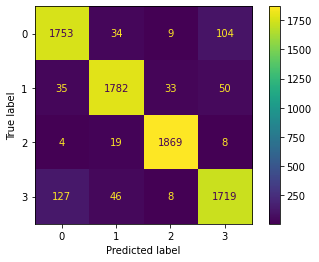

In [75]:
# confusion matrix
cm = confusion_matrix(test_df['label'], preds_flat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

plt.show()

In [76]:
# calculating precision, recall, f1score, support
precision, recall, fscore, support = score(test_df['label'], preds_flat)

print('precision: {}' .format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))



precision: [0.91349661 0.94736842 0.97394476 0.9138756 ]
recall: [0.92263158 0.93789474 0.98368421 0.90473684]
fscore: [0.91804137 0.94260778 0.97879026 0.90928326]
support: [1900 1900 1900 1900]


In [77]:
# accuracy
print("Accuracy:", accuracy_score(test_df['label'], preds_flat)) 

print("Accuracy Percentage {} %:".format(100*accuracy_score(test_df['label'], preds_flat)))

Accuracy: 0.9372368421052631
Accuracy Percentage 93.72368421052632 %:


## Conclusions

*   As can be seen from the results above, the success of the models does not vary
by a great margin.

*   Precision, recall, F1-score, and support were computed for each of the four.

*   90.3% accuracy was determined to be the model's total accuracy.

*   The precision values varied from 0.862 to 0.934, showing that the model's predictions for all classes were fairly accurate.

*   The model was able to recognise the majority of the instances for each class, according to the recall values, which varied from 0.830 to 0.975.

*   The harmonic mean of precision and recall, or F1-scores, varied from 0.845 to 0.954, showing a balance between the two for all classes.